<a href="https://colab.research.google.com/github/ampnb/eeg-meditation/blob/main/eeg_group_60mins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --id 1tf3y7AsGztdlYR07QJM_2bQXm9OTqkCg

In [ ]:
!gdown --id 1CDj-IwNtgXsnDHoKUgc5msEX1xgBYz65

In [ ]:
!unzip -o sunday-non-meditator.zip

In [ ]:
!unzip -o sunday-meditator.zip

In [ ]:
!pip install -U mne

In [ ]:
pip install mne

In [8]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import f_oneway

In [19]:
meditator_data_path = '/content/sunday-meditator'
non_meditator_data_path = '/content/sunday-non-meditator'

In [20]:
frequency_bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 14), 'Beta': (14, 30), 'Gamma': (30, 40)}
time_segments = [(1 * 60, 10 * 60), (11 * 60, 20 * 60), (21 * 60, 30 * 60), (31 * 60, 40 * 60), (41 * 60, 50 * 60), (51*60, 60*60)]

In [24]:
def load_and_trim(file_path):
    raw = mne.io.read_raw_fif(file_path, preload=True)

    # Trim the recording to 3600 seconds if it's longer
    if raw.times[-1] / raw.info['sfreq'] > 3600:
        raw.crop(tmin=0, tmax=3600)

    return raw



# Calculate PSD and Extract Band Powers

In [25]:
def calculate_band_powers(data_path):
    band_powers = {band: [] for band in frequency_bands.keys()}

    for file_name in sorted(os.listdir(data_path)):
        if file_name.endswith('.fif'):
            file_path = os.path.join(data_path, file_name)
            raw = load_and_trim(file_path)

            for start, end in time_segments:
                # Extract data for the current segment
                start_sample = int(start * raw.info['sfreq'])
                end_sample = int(end * raw.info['sfreq'])
                segment_data = raw.get_data(start=start_sample, stop=end_sample)

                # Calculate PSD for the segment using psd_array_welch
                psd, freqs = mne.time_frequency.psd_array_welch(segment_data, sfreq=raw.info['sfreq'], fmin=0.5, fmax=40, n_fft=2048, n_overlap=1024, verbose=False)

                # Calculate power in each frequency band
                for band, (fmin, fmax) in frequency_bands.items():
                    idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
                    band_power = psd[:, idx_band].mean(axis=1).mean()
                    band_powers[band].append(band_power)

    return band_powers



# Process EEG Data for Both Groups

In [ ]:
meditator_band_powers = calculate_band_powers(meditator_data_path)
non_meditator_band_powers = calculate_band_powers(non_meditator_data_path)


# Statistical Analysis

In [29]:
from scipy.stats import ttest_ind

# Initialize a dictionary to store the p-values for each band
p_values = {}

for band in frequency_bands.keys():
    meditator_powers = np.array(meditator_band_powers[band])
    non_meditator_powers = np.array(non_meditator_band_powers[band])

    t_stat, p_val = ttest_ind(meditator_powers, non_meditator_powers)
    significance = "significant" if p_val < 0.05 else "not significant"

    print(f"{band} band: p-value = {p_val:.4f} ({significance})")



Delta band: p-value = 0.3656 (not significant)
Theta band: p-value = 0.3434 (not significant)
Alpha band: p-value = 0.1606 (not significant)
Beta band: p-value = 0.0517 (not significant)
Gamma band: p-value = 0.0364 (significant)


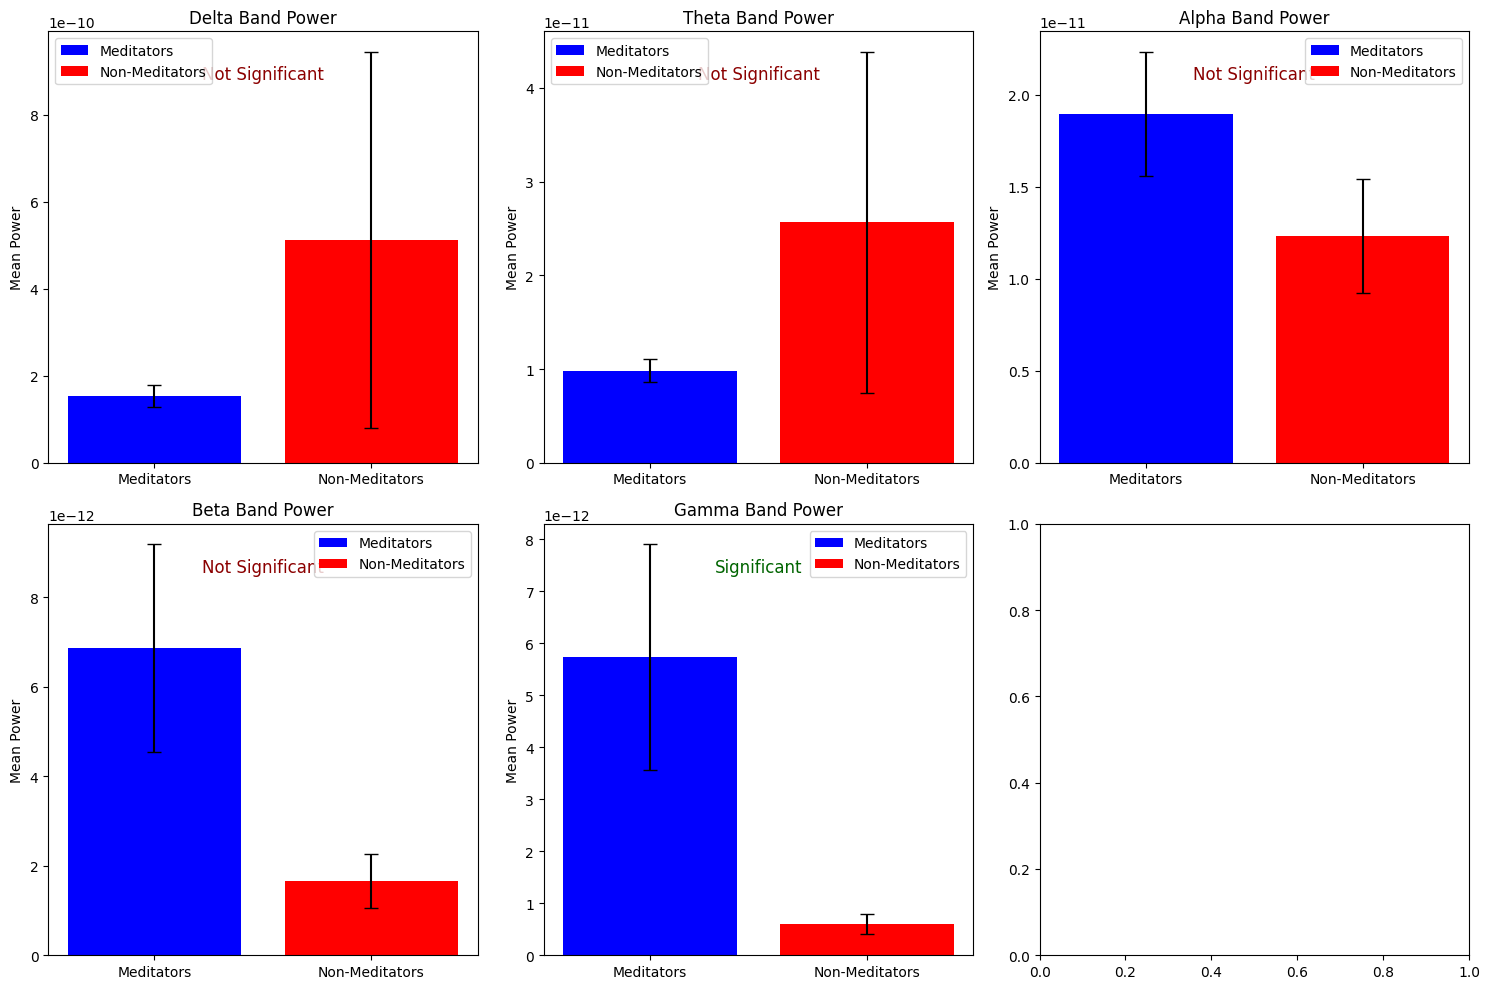

In [30]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, band in enumerate(frequency_bands.keys()):
    meditator_means = np.mean(meditator_band_powers[band])
    non_meditator_means = np.mean(non_meditator_band_powers[band])
    sem_meditators = np.std(meditator_band_powers[band]) / np.sqrt(len(meditator_band_powers[band]))  # Standard Error Mean
    sem_non_meditators = np.std(non_meditator_band_powers[band]) / np.sqrt(len(non_meditator_band_powers[band]))

    axs[i].bar('Meditators', meditator_means, yerr=sem_meditators, color='blue', label='Meditators', capsize=5)
    axs[i].bar('Non-Meditators', non_meditator_means, yerr=sem_non_meditators, color='red', label='Non-Meditators', capsize=5)

    axs[i].set_title(f'{band} Band Power')
    axs[i].set_ylabel('Mean Power')
    axs[i].legend()

    # Determine significance
    _, p_val = ttest_ind(meditator_band_powers[band], non_meditator_band_powers[band])
    significance_text = "Significant" if p_val < 0.05 else "Not Significant"
    axs[i].text(0.5, 0.9, significance_text, ha='center', va='center', transform=axs[i].transAxes, fontsize=12, color='darkgreen' if p_val < 0.05 else 'darkred')

plt.tight_layout()
plt.show()

